In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pyplot import imread
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.cluster import KMeans


In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
df = pd.read_csv('data/mm_master_demos.csv',index_col = 0)
map_boundaries= pd.read_csv('data/map_data.csv',index_col = 0)



# Cleanning data 

#### Preprocessing the data

While there were 11 CSV’s we only used 3 in our analysis, data for duels, grenade throws and map data. The reason for this was because some of the other datasets were missing key values which we used throughout such as attacker rank or the team that won the overall round. This made the data to be not very useful. 


We also did a couple of other things like changing the team names to be consistent “Team 1” and “Team 2” to make it a bit more appropriate. We have also dropped the data on a few maps that did not have similar amounts of data. This also helped us to focus more on the more popular maps. 

Another main aspect that we worked on is the attack and victims positions. This was necessary as the data was recorded with negative values and to fix this we used the maps boundaries on the data and format it to the right location. This was very useful as we were able to accurately pinpoint the location of the attack and plot it. Then we replaced the old values with the new values to keep all the data in the same data frame. 


In [6]:

main_maps = ['de_cache', 'de_cbble', 'de_dust2', 'de_inferno', 'de_mirage', 'de_overpass', 'de_train']
df = df[df['map'].isin(main_maps)]
df = df.reset_index(drop=True)


In [7]:

new_att_col = []
new_att_col = df['att_team']


for i in range(0, len(df)):
    if( df['att_team'][i] == 'Animal Style' ):
        new_att_col[i] = ("Team 1")
    elif(df['att_team'][i] == 'Hentai Hooligans'):
        new_att_col[i] = ("Team 2")
        

In [8]:

new_vic_col = []
new_vic_col = df['vic_team']

for i in range(0, len(df)):
    if( df['vic_team'][i] == 'Animal Style' ):
        new_vic_col[i] = ("Team 1")
    elif(df['vic_team'][i] == 'Hentai Hooligans'):
        new_vic_col[i] = ("Team 2")
df['att_team'] = new_att_col 
df['vic_team'] = new_vic_col

cleanData = df
cleanData.head()

,file,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,...,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1.0,8482.0,133.0582,Team 1,Team 2,CounterTerrorist,Terrorist,...,7.656120e+16,17.0,1473.847,1351.358,662.170,772.748,PISTOL_ROUND,2950.0,3850.0,16.0
1,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1.0,8600.0,134.9023,Team 1,Team 2,CounterTerrorist,Terrorist,...,7.656120e+16,17.0,-1211.723,1060.813,-1184.006,1153.343,PISTOL_ROUND,2950.0,3850.0,16.0
2,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1.0,8610.0,135.0586,Team 2,Team 1,Terrorist,CounterTerrorist,...,7.656120e+16,16.0,-1153.584,1163.131,-1198.015,1050.423,PISTOL_ROUND,2950.0,3850.0,16.0
3,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1.0,8624.0,135.2774,Team 1,Team 2,CounterTerrorist,Terrorist,...,7.656120e+16,17.0,-1173.053,1044.365,-1141.785,1190.089,PISTOL_ROUND,2950.0,3850.0,16.0
4,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1.0,8632.0,135.4024,Team 2,Team 1,Terrorist,CounterTerrorist,...,7.656120e+16,16.0,-1142.522,1200.967,-1157.690,1050.702,PISTOL_ROUND,2950.0,3850.0,16.0


In [9]:
main_data = map_boundaries.loc[cleanData['map']]
main_data[['att_pos_x',
           'att_pos_y',
           'vic_pos_x',
           'vic_pos_y']] = (cleanData.set_index('map')[['att_pos_x',
                                                        'att_pos_y',
                                                        'vic_pos_x',
                                                        'vic_pos_y']])


In [10]:
main_data['att_pos_x'] = (main_data['ResX']*(main_data['att_pos_x']-main_data['StartX']))
                            /(main_data['EndX']-main_data['StartX'])
    
main_data['att_pos_y'] = (main_data['ResY']*(main_data['att_pos_y']-main_data['StartY']))
                            /(main_data['EndY']-main_data['StartY'])
    
main_data['vic_pos_x'] = (main_data['ResX']*(main_data['vic_pos_x']-main_data['StartX']))
                            /(main_data['EndX']-main_data['StartX'])
    
main_data['vic_pos_y'] = (main_data['ResY']*(main_data['vic_pos_y']-main_data['StartY']))
                            /(main_data['EndY']-main_data['StartY'])


In [11]:
cleanData[['att_pos_x',
           'att_pos_y',
           'vic_pos_x',
           'vic_pos_y']] = main_data[['att_pos_x',
                                      'att_pos_y',
                                      'vic_pos_x',
                                      'vic_pos_y']].values

# Analysis 

In [12]:
all_pistols = ['USP', 'Glock', 'P2000', 'P250', 'Tec9', 'FiveSeven', 'Deagle', 'DualBarettas', 'CZ']


cleanData_pistol = cleanData[(cleanData['round'].isin([1,16])) & (cleanData['wp'].isin(all_pistols))]

print("Total Number of Pistol Rounds: %i" % cleanData_pistol.groupby(['file', 'round'])['tick'].first().count())



Total Number of Pistol Rounds: 857


#### K Means cluster Analysis 



de_dust2


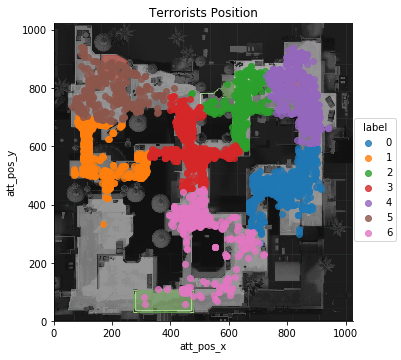

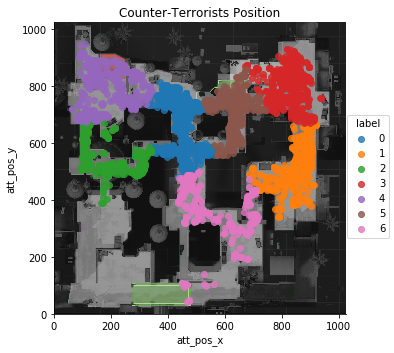

In [31]:
sample_map = "de_dust2"

print(sample_map)
KMeans_clustoring_by_Location(sample_map)


def KMeans_clustoring_by_Location(sample_map):

    curr_map = imread('data/maps/'+sample_map+'.png') 

    
    terr_df =  cleanData_pistol.loc[(cleanData_pistol.map == sample_map) & (cleanData_pistol.att_side == 'Terrorist')]
    cont_df = cleanData_pistol.loc[(cleanData_pistol.map ==  sample_map) & (cleanData_pistol.att_side == 'CounterTerrorist')]

    
    terr_plot_kmt = terr_df[['att_pos_x', 'att_pos_y']].copy()
    kmeans = KMeans(n_clusters=7)
    kmeans.fit(terr_plot_kmt)
    terr_plot_kmt['label'] = kmeans.predict(terr_plot_kmt)
    sns.lmplot('att_pos_x', 'att_pos_y', data=terr_plot_kmt, fit_reg=False, hue='label')
    plt.imshow(curr_map, zorder=0,extent=[0.0, 1024, 0., 1024])
    plt.title('Terrorists Position')



   
    cont_plot_kmt = cont_df[['att_pos_x', 'att_pos_y']].copy()
    kmeans = KMeans(n_clusters=7)
    kmeans.fit(cont_plot_kmt)
    cont_plot_kmt['label'] = kmeans.predict(cont_plot_kmt)
    sns.lmplot('att_pos_x', 'att_pos_y', data=cont_plot_kmt, fit_reg=False, hue='label')
    plt.imshow(curr_map, zorder=0,extent=[0.0, 1024, 0., 1024])
    plt.title('Counter-Terrorists Position')
    

    

## Heat map of Pistol rounds

We only used dust2 BECAUSE it is the most well know and used maps when compared to the others. Form the Heat maps we can see that there are a few key locations to look out for such as:
* The corners
* Mid
* Long doors
* near the bomb sites.

One of the features of the game is that you peek at the corners and this provides a lot of advantage as the possibility of getting hit is reduced by the visibility remains similar. Hence many of the players tend to try and use that ASPECT OF THE GAME AS much as possible. But normally the better players use this situation by using other items such as flash bangs, smoke grenades, and try to eliminate as many players as possible. More on the gameplay with smoke grenades will be discussed by matt.  When compared to any other location in the map the Long Doors is the location that has the most frequent area with high damage given to the counter-terrorist. The main reason why this is such a highly contested area is due to the fact that both of the counter-terrorist and the terrorists have strong corners where the players can use the corner tactics trying to get an advantage over the other team. Another reason is due to the fact that it's much closer to the bomb site.    

MID and the catwalk is a more populated area due to the fact its right in the centre of the map but still provides two different pathways to the bomb site. But this is also advantageous to the Counter terrorists as they will have the chance of directly take out the entire team given there is good coordination between the players in the team.

When graphing the actual Heat maps i used the subset data of just the pistol rounds in the MM_demos data set. The heatmaps were plotted with the use of SNS Library using the kdeplot. I have also created a function to reproduce similar heatmaps with just the use of the map name. This has been extremely useful when trying to compare maps to get insights into the use of visual data. 


In [11]:
def heat_map_by_Location(map_name):
                   
    # The term sample map can be changed to provide diffrent results 
    sample_map = map_name

    curr_map = imread('data/maps/'+sample_map+'.png') 
    fig,(ax1, ax2) = plt.subplots(1,2,figsize=(18,16))

#     Aligns the image to the graph and limits the boundraies of the ploting to between 0 and 1024(sie of the map)
    ax1.imshow(curr_map, zorder=0, extent=[0.0, 1024, 0., 1024])
    ax2.imshow(curr_map, zorder=0, extent=[0.0, 1024, 0., 1024])

    plt.xlim(0,1024)
    plt.ylim(0,1024)

#     plotting the Terrorist side
    plot_cleanData = cleanData_pistol.loc[(cleanData_pistol.map == sample_map) & (cleanData_pistol.att_side == 'Terrorist')]
#     plots the x and the y position of the Terroists 
    sns.kdeplot(plot_cleanData['att_pos_x'], plot_cleanData['att_pos_y'], cmap='Reds', bw=15, ax=ax1)
    
    ax1.set_title('Terrorists Attacking')
#   
    #     plotting the Counter - Terrorist side
    plot_cleanData = cleanData_pistol.loc[(cleanData_pistol.map == sample_map) & (cleanData_pistol.att_side == 'CounterTerrorist')]
    #     plots the x and the y position of the Counter Terroists 
    sns.kdeplot(plot_cleanData['att_pos_x'], plot_cleanData['att_pos_y'], cmap='Blues', bw=15, ax=ax2)
    
    ax2.set_title('Counter-Terrorists Attacking')

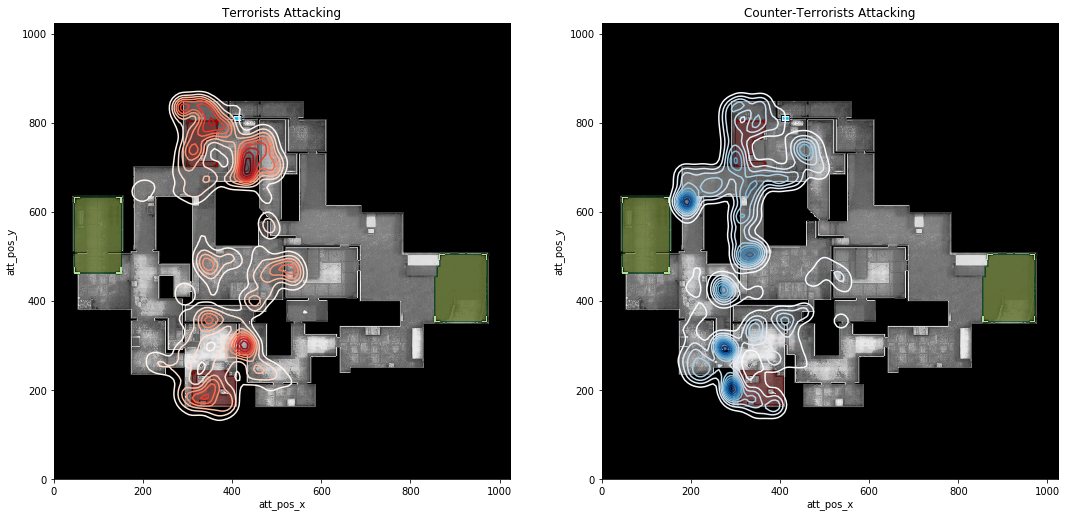

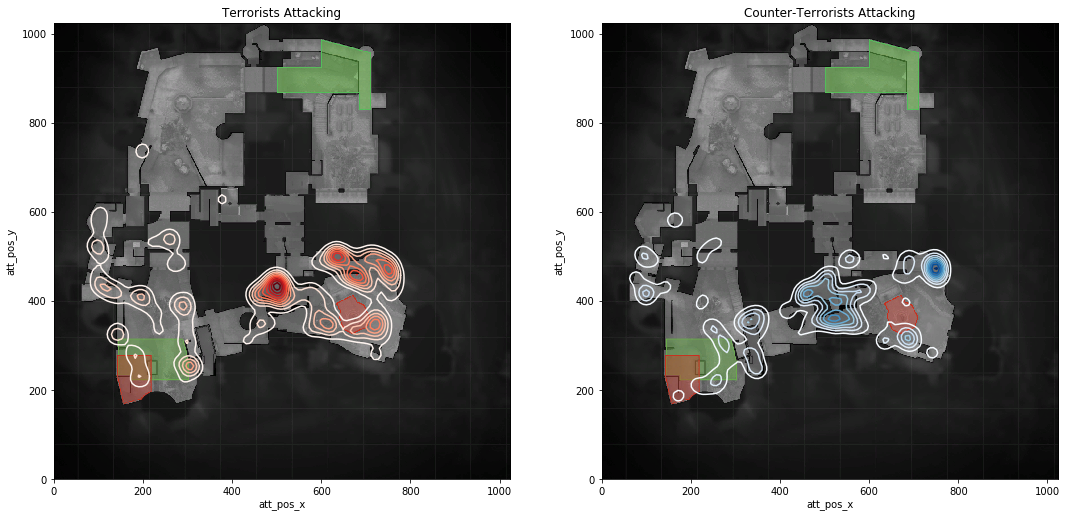

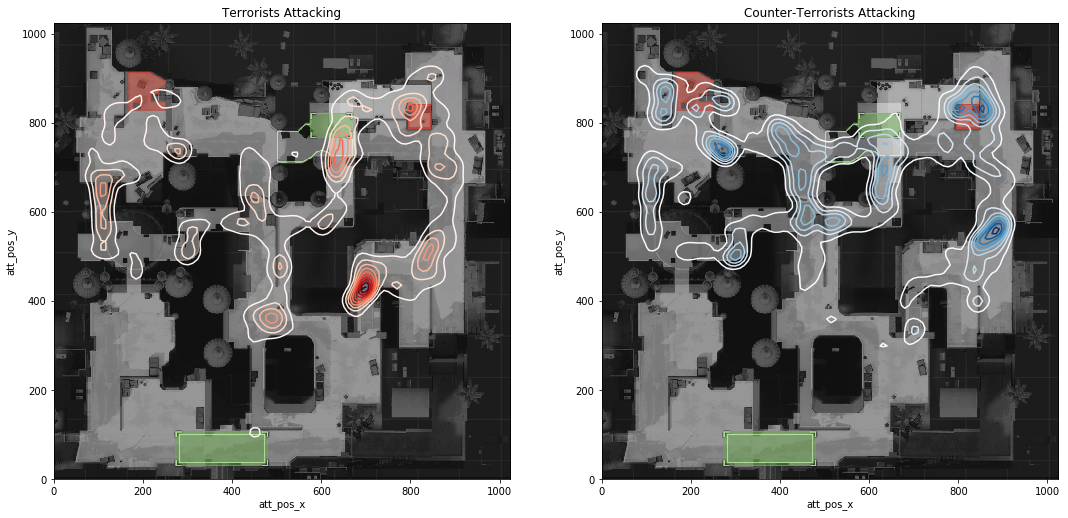

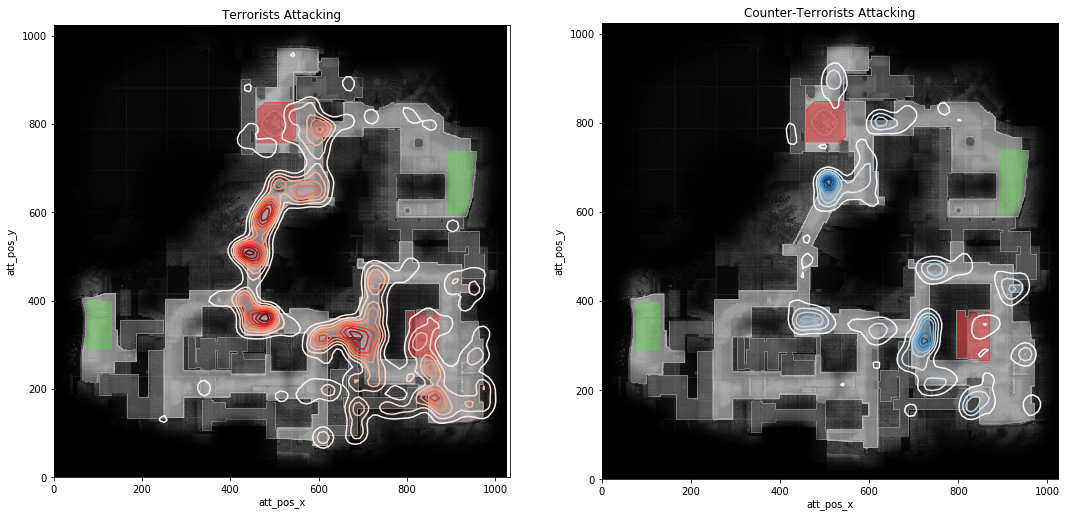

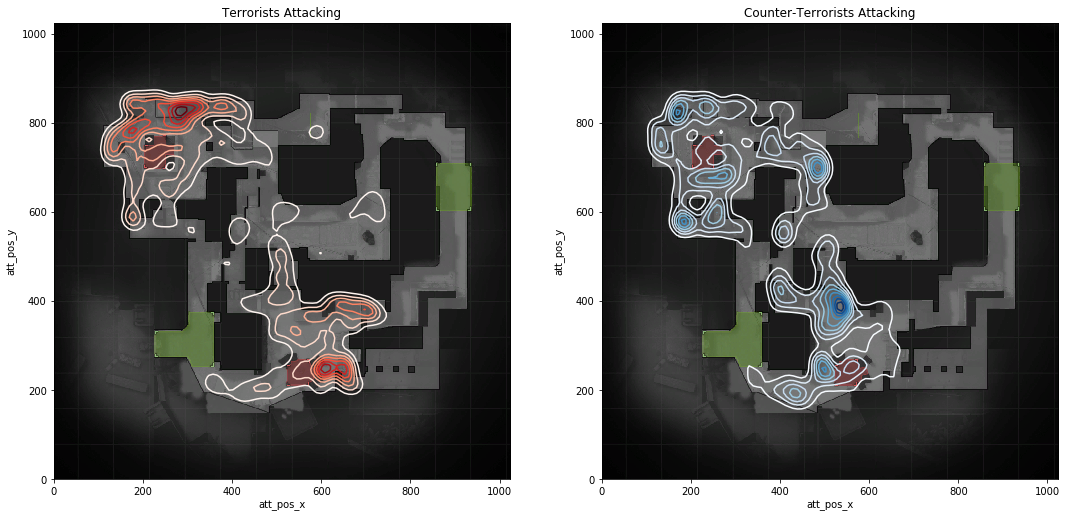

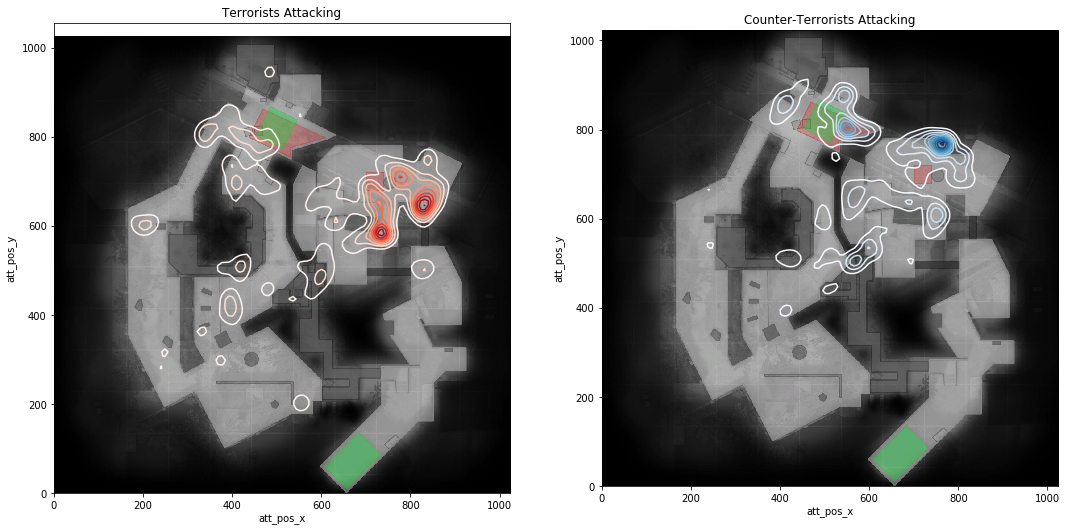

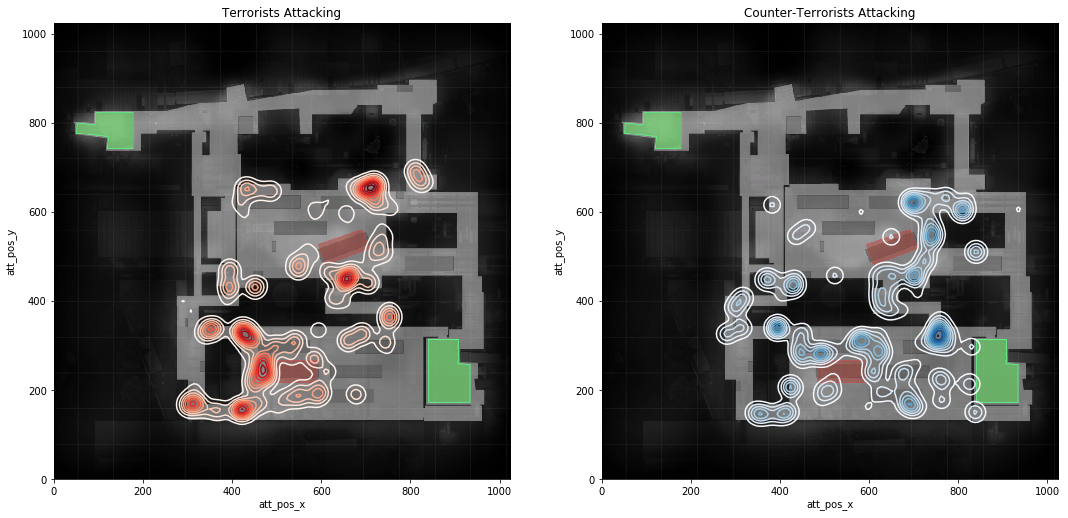

In [12]:
for i in range(0, len(main_maps)):
    heat_map_by_Location(main_maps[i])

with the help of these maps we can get more insightfull information such as the locations that are highly populated adn this can help when trying to create new strategies and tatics to out play the opponents 